### **Bài thực hành 3: Hugging Face**
* **Tên sinh viên:** Huỳnh Thế Hy
* **Mã số sinh viên:** 051205009083
---
### **Exercise 2: Finetuning một mô hình đã được huấn luyện trước cho bài toán phân loại văn bản nhị phân**

Thực hiện quy trình hoàn chỉnh để tinh chỉnh một mô hình ngôn ngữ đã được huấn luyện trước (pre-trained model) cho một tác vụ cụ thể: phân loại cảm xúc trên bộ dữ liệu đánh giá phim IMDB. Đây là một ví dụ kinh điển của bài toán phân loại văn bản nhị phân (tích cực/tiêu cực).

#### **Bước 1 & 2: Tải thư viện và bộ dữ liệu**

Thư viện `datasets` để tải dữ liệu và `evaluate` để tính toán các độ đo. Bộ dữ liệu "imdb" là một bộ dữ liệu tiêu chuẩn chứa các bài đánh giá phim và nhãn tương ứng (0 cho tiêu cực, 1 cho tích cực).

Để quá trình huấn luyện diễn ra nhanh chóng, Em sẽ chỉ lấy một tập con nhỏ của dữ liệu để làm ví dụ.

In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tải bộ dữ liệu IMDB
print("Đang tải bộ dữ liệu IMDB...")
dataset = load_dataset("imdb")
print("Tải dữ liệu thành công!")

# Để tiết kiệm thời gian, chúng ta sẽ tạo một tập dữ liệu con nhỏ hơn
# Lấy 1000 mẫu cho tập huấn luyện và 500 mẫu cho tập kiểm tra
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000))
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(500))

print("\nKích thước tập huấn luyện con:", len(small_train_dataset))
print("Kích thước tập kiểm tra con:", len(small_test_dataset))
print("\nVí dụ một mẫu dữ liệu:")
print(small_train_dataset[0])

c:\Users\VTPT\Downloads\CODE\Pratice-Deep_learning\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Đang tải bộ dữ liệu IMDB...
Tải dữ liệu thành công!

Kích thước tập huấn luyện con: 1000
Kích thước tập kiểm tra con: 500

Ví dụ một mẫu dữ liệu:
{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1}


#### **Bước 3: Tải mô hình Pre-trained và Tokenizer**

Em sẽ sử dụng `distilbert-base-uncased`, một phiên bản nhỏ hơn và nhanh hơn của BERT, rất phù hợp cho việc tinh chỉnh. `AutoTokenizer` sẽ tự động tải tokenizer tương ứng với mô hình, và `AutoModelForSequenceClassification` sẽ tải kiến trúc mô hình với một lớp phân loại ở trên cùng.

In [2]:
# Tên của mô hình pre-trained
model_name = "distilbert-base-uncased"

# Tải tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tải mô hình với 2 nhãn (tiêu cực, tích cực)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### **Bước 4: Tiền xử lý dữ liệu**

Mô hình không thể hiểu văn bản thô. Em chuyển đổi văn bản thành các con số mà mô hình có thể xử lý. Quá trình này được gọi là **tokenization**. Em sẽ tạo một hàm để tokenize văn bản và áp dụng nó cho toàn bộ bộ dữ liệu.

In [3]:
# Tạo hàm tiền xử lý
def preprocess_function(examples):
    # Tokenize văn bản, cắt bớt nếu dài hơn 512 token
    return tokenizer(examples["text"], truncation=True, max_length=512)

# Áp dụng hàm tiền xử lý cho tập train và test
tokenized_train_dataset = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = small_test_dataset.map(preprocess_function, batched=True)

print("\nMột mẫu dữ liệu sau khi tokenize:")
print(tokenized_train_dataset[0])

Map: 100%|██████████| 500/500 [00:00<00:00, 3758.02 examples/s]


Một mẫu dữ liệu sau khi tokenize:
{'text': 'There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier\'s plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it\'s the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all...', 'label': 1, 'input_ids': [101, 2045, 2003, 2053, 7189, 2012, 2035, 2090, 3481, 3771, 1998, 6337, 2099, 2021, 1996, 2755, 2008, 2119, 2024, 2610, 2186, 2055, 6355, 6997, 1012, 6337, 2099, 3504,

#### **Bước 5: Định nghĩa tham số huấn luyện và hàm tính toán độ đo**


In [4]:
# Tải độ đo accuracy
metric = evaluate.load("accuracy")

# Định nghĩa hàm tính toán độ đo
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

#### **Bước 6: Định nghĩa tham số huấn luyện và tạo đối tượng Trainer**


In [5]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",          # Đánh giá sau mỗi epoch
    save_strategy="epoch",          # Lưu checkpoint sau mỗi epoch
    logging_strategy="epoch",       # Ghi log sau mỗi epoch
    load_best_model_at_end=True,    # Tải mô hình tốt nhất khi kết thúc
)

# Tạo đối tượng Trainer để quản lý quá trình huấn luyện và đánh giá
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

C:\Users\VTPT\AppData\Local\Temp\ipykernel_8780\1466481241.py:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


#### **Bước 7: Bắt đầu quá trình fine-tuning**

In [6]:
print("\nBắt đầu quá trình tinh chỉnh mô hình...")
trainer.train()
print("Hoàn tất tinh chỉnh!")


Bắt đầu quá trình tinh chỉnh mô hình...


c:\Users\VTPT\Downloads\CODE\Pratice-Deep_learning\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.601900,0.362751,0.858000
2,0.298000,0.317294,0.868000
3,0.177800,0.307870,0.876000


c:\Users\VTPT\Downloads\CODE\Pratice-Deep_learning\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\VTPT\Downloads\CODE\Pratice-Deep_learning\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Hoàn tất tinh chỉnh!


#### **Bước 8: Đánh giá mô hình trên tập huấn luyện**

In [9]:
print("\nĐang đánh giá mô hình trên tập kiểm tra...")
eval_results = trainer.evaluate()

print("\n--- Kết quả đánh giá ---")
for key, value in eval_results.items():
    print(f"{key}: {value:.4f}")


Đang đánh giá mô hình trên tập kiểm tra...


c:\Users\VTPT\Downloads\CODE\Pratice-Deep_learning\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Kết quả đánh giá ---
eval_loss: 0.3079
eval_accuracy: 0.8760
eval_runtime: 72.2883
eval_samples_per_second: 6.9170
eval_steps_per_second: 0.4430
epoch: 3.0000


#### **Bước 9: Phân tích kết quả và vẽ ma trận nhầm lẫn**

c:\Users\VTPT\Downloads\CODE\Pratice-Deep_learning\venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


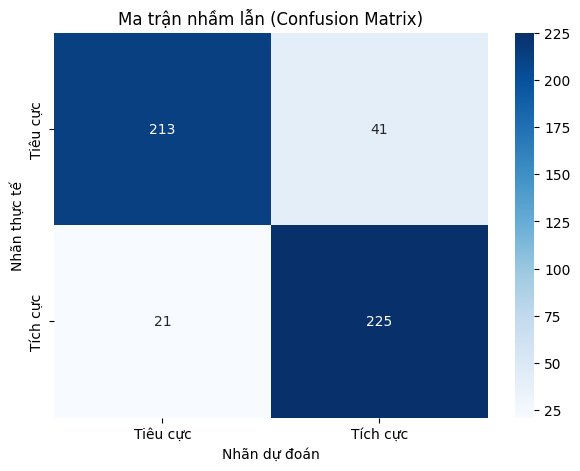

In [10]:
# Dự đoán trên tập test
predictions = trainer.predict(tokenized_test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)
true_labels = tokenized_test_dataset["label"]
# Tính ma trận nhầm lẫn
cm = confusion_matrix(true_labels, predicted_labels)
# Vẽ ma trận nhầm lẫn để trực quan hóa kết quả
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tiêu cực', 'Tích cực'], yticklabels=['Tiêu cực', 'Tích cực'])
plt.xlabel('Nhãn dự đoán')
plt.ylabel('Nhãn thực tế')
plt.title('Ma trận nhầm lẫn (Confusion Matrix)')
plt.show()

**Báo cáo và phân tích kết quả:**

1.  **Hiệu suất mô hình:** Dựa vào kết quả từ hàm `evaluate()`, Ta có thể thấy độ chính xác (accuracy) của mô hình trên tập dữ liệu kiểm tra. Một mô hình được tinh chỉnh tốt thường sẽ đạt độ chính xác cao (ví dụ: trên 85-90% cho bài toán này, ngay cả với một tập dữ liệu con). Điều này cho thấy mô hình đã học được cách phân biệt giữa các bài đánh giá phim tích cực và tiêu cực.

2.  **Phân tích Ma trận nhầm lẫn (Confusion Matrix):**
    *   **True Positives (TP)** và **True Negatives (TN)** (các giá trị trên đường chéo chính) cho biết số lượng mẫu được mô hình phân loại đúng. Giá trị càng cao càng tốt.
    *   **False Positives (FP)** và **False Negatives (FN)** (các giá trị không nằm trên đường chéo chính) biểu thị số lượng mẫu bị phân loại sai. Giá trị càng thấp càng tốt.
    *   Nhìn vào ma trận, Ta có thể đánh giá xem mô hình có xu hướng nhầm lẫn loại cảm xúc nào hơn. Ví dụ, nếu số FN cao, nghĩa là mô hình thường dự đoán sai các mẫu tích cực thành tiêu cực.

**Kết luận:**
Trong bài này ta đã thực hiện việc tinh chỉnh một mô hình ngôn ngữ lớn cho tác vụ phân loại văn bản nhị phân. Bắt đầu từ một mô hình `distilbert-base-uncased` có kiến thức tổng quát, Ta đã "chuyên môn hóa" nó để hiểu sắc thái trong các bài đánh giá phim và đạt được hiệu suất phân loại tốt trên dữ liệu thực tế. Quy trình này cho thấy sức mạnh của học chuyển giao (transfer learning) trong lĩnh vực xử lý ngôn ngữ tự nhiên.
